In [ ]:
import metview as mv
import rioxarray 
import xarray
from shapely.geometry import (Polygon, mapping)
import geopandas

mv.setoutput('jupyter', output_font_scale=1.5, plot_widget=False)

#### Procipitación

In [ ]:
precipitacion_rds = rioxarray.open_rasterio('./cerro_saroche/cdsapi/total_precipitation.grib',
                              masked=True
                              )\
                              .squeeze()

ERROR: Ran out of file reading SECT0


#### Rectangulo del parque

In [ ]:
# Rectangulo definido al parque
from shapely.geometry import (Polygon, mapping)
import geopandas

poligono = Polygon([
                  (-69.93,10.01),
                  (-69.93,10.31),
                  (-69.33,10.31),
                  (-69.33,10.01),
                  (-69.93,10.01)
                        ])

parque_rectangulo = geopandas.GeoSeries(poligono, crs = precipitacion_rds.rio.crs)

# Area del parque
park_boundary = geopandas.read_file('./cerro_saroche/poligono_cerro_saroche/cerro_saroche.shp')
park_bound_sin = park_boundary.to_crs(precipitacion_rds.rio.crs)

#### Elevación

In [ ]:
elevacion_rds = rioxarray.open_rasterio('./cerro_saroche/SRTMGL3/elevacion.nc',
                              masked=True
                              )\
                              .squeeze()\
                              .to_dataset()

elevacion = elevacion_rds.rio.reproject(precipitacion_rds.rio.crs)
elevacion

<xarray.Dataset>
Dimensions:      (x: 4801, y: 3601)
Coordinates:
  * x            (x) float64 -72.0 -72.0 -72.0 -72.0 ... -68.0 -68.0 -68.0 -68.0
  * y            (y) float64 12.0 12.0 12.0 12.0 12.0 ... 9.003 9.002 9.001 9.0
    band         int64 1
    spatial_ref  int64 0
Data variables:
    elevacion    (y, x) float32 41.0 43.0 43.0 42.0 44.0 ... 80.0 81.0 77.0 74.0

In [ ]:
# elevacion del parque
elevacion_park = elevacion.rio.clip(park_bound_sin.geometry.apply(mapping),
                    all_touched=True,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

elevacion_park

<xarray.Dataset>
Dimensions:      (y: 288, x: 562)
Coordinates:
  * y            (y) float64 10.3 10.3 10.3 10.3 ... 10.07 10.06 10.06 10.06
  * x            (x) float64 -69.88 -69.88 -69.88 ... -69.41 -69.41 -69.41
    band         int64 1
    spatial_ref  int64 0
Data variables:
    elevacion    (y, x) float32 dask.array<chunksize=(288, 562), meta=np.ndarray>

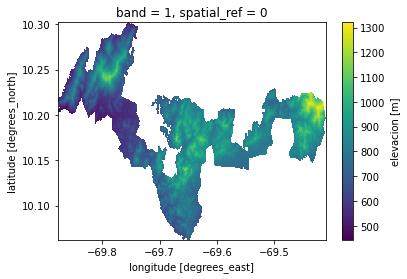

In [ ]:
elevacion_park.elevacion.plot()

In [ ]:
elevacion_park.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_cerro_saroche_clip.nc')

In [ ]:
# elevacion del parque
elevacion_rect = elevacion.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=True,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

elevacion_rect

<xarray.Dataset>
Dimensions:      (y: 361, x: 721)
Coordinates:
  * y            (y) float64 10.31 10.31 10.31 10.31 ... 10.01 10.01 10.01 10.01
  * x            (x) float64 -69.93 -69.93 -69.93 ... -69.33 -69.33 -69.33
    band         int64 1
    spatial_ref  int64 0
Data variables:
    elevacion    (y, x) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>

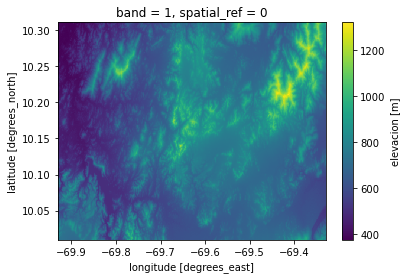

In [ ]:
elevacion_rect.elevacion.plot()

In [ ]:
elevacion_rect.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_rectangulo_clip.nc')

#### Regrillado elevación

##### Grilla Precipitación

In [ ]:
import warnings
warnings.filterwarnings("ignore")


rds = precipitacion_rds
rds_trgrilla = elevacion
band = 'elevacion'
x_name='x'
y_name='y'

#def grilla_final(rds, rds_trgrilla, band, x_name='x', y_name='y'):

y = rds[y_name].to_numpy()
x = rds[x_name].to_numpy()

list_grid = []
for i, i_ in enumerate(y[:-1]):
  list_i = []
  for j, j_ in enumerate(x[:-1]):
    poly = Polygon( [(x[j],y[i,]),(x[j+1],y[i]),(x[j+1],y[i+1]),(x[j],y[i+1]),(x[j],y[i,])] )
    poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
    region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                          all_touched=False,
                          from_disk=True)[band]
    list_i.append({ 'x':i_,
                    'y':j_,
                    'mean': float(region.mean()),
                    'median': float(region.median()),
                    'max': float(region.max()),
                    'centroide': (float(poligono.centroid.x), float(poligono.centroid.y))
                    }) 
  
  list_grid.append(list_i)

In [ ]:
centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))

In [ ]:
fieldset = [{
              "gridType": "regular_ll",
              "Nx": len([round(x,2) for x in centroide_x]),
              "Ny": len([round(y,2) for y in centroide_y]),
              "distinctLatitudes": [round(y,2) for y in centroide_y],
              "distinctLongitudes": [round(x,2) for x in centroide_x],
              "paramId": 1,
              "shortName": f"{band}_media",
              "values": media,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len([round(x,2) for x in centroide_x]),
              "Ny": len([round(y,2) for y in centroide_y]),
              "distinctLatitudes":[round(y,2) for y in centroide_y],
              "distinctLongitudes": [round(x,2) for x in centroide_x],
              "paramId": 2,
              "shortName": f"{band}_mediana",
              "values": mediana,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len([round(x,2) for x in centroide_x]),
              "Ny": len([round(y,2) for y in centroide_y]),
              "distinctLatitudes": [round(y,2) for y in centroide_y],
              "distinctLongitudes":[round(x,2) for x in centroide_x],
              "paramId": 3,
              "shortName": f"{band}_maxima",
              "values": maximo,
              "dataDate": 20211216,
              "dataTime": 1200
              }
              ]

ds = xarray.open_dataset(fieldset, engine="cfgrib")
ds = ds.rio.write_crs(precipitacion_rds.rio.crs)

ds.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

In [ ]:
# fieldset = [{
#               "gridType": "regular_ll",
#               "Nx": len(x[:-1]),
#               "Ny": len(y[:-1]),
#               "distinctLatitudes": y[:-1],
#               "distinctLongitudes": x[:-1],
#               "paramId": 1,
#               "shortName": f"{band}_media",
#               "values": media,
#               "dataDate": 20211216,
#               "dataTime": 1200
#               },
#               {
#               "gridType": "regular_ll",
#               "Nx": len(x[:-1]),
#               "Ny": len(y[:-1]),
#               "distinctLatitudes": y[:-1],
#               "distinctLongitudes": x[:-1],
#               "paramId": 2,
#               "shortName": f"{band}_mediana",
#               "values": mediana,
#               "dataDate": 20211216,
#               "dataTime": 1200
#               },
#               {
#               "gridType": "regular_ll",
#               "Nx": len(x[:-1]),
#               "Ny": len(y[:-1]),
#               "distinctLatitudes": y[:-1],
#               "distinctLongitudes": x[:-1],
#               "paramId": 3,
#               "shortName": f"{band}_maxima",
#               "values": maximo,
#               "dataDate": 20211216,
#               "dataTime": 1200
#               }
#               ]

# ds = xarray.open_dataset(fieldset, engine="cfgrib")
# ds = ds.rio.write_crs(precipitacion_rds.rio.crs)

In [ ]:
ds.rio.crs

CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [ ]:
ds

<xarray.Dataset>
Dimensions:            (latitude: 5, longitude: 8)
Coordinates:
    time               datetime64[ns] ...
  * latitude           (latitude) float64 10.36 10.26 10.16 10.06 9.96
  * longitude          (longitude) float64 -69.98 -69.88 ... -69.38 -69.28
    spatial_ref        int64 0
Data variables:
    elevacion_media    (latitude, longitude) float32 ...
    elevacion_mediana  (latitude, longitude) float32 ...
    elevacion_maxima   (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.7
    history:      2022-06-04T19:46 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

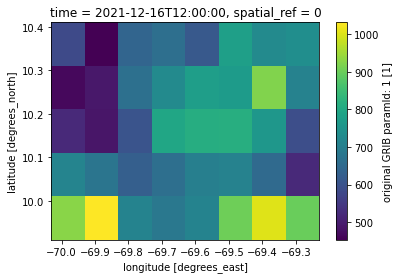

In [ ]:
ds.elevacion_media.plot()

In [ ]:
# elevacion del parque
ds_rect = ds.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=True,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

#ds_rect.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

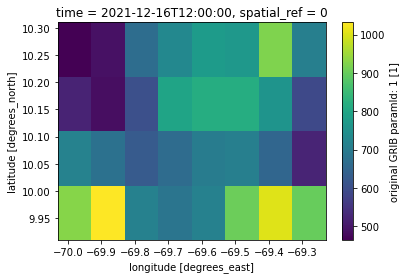

In [ ]:
ds_rect.elevacion_media.plot()

In [ ]:
ds_rect

<xarray.Dataset>
Dimensions:            (latitude: 4, longitude: 8)
Coordinates:
  * latitude           (latitude) float64 10.26 10.16 10.06 9.96
  * longitude          (longitude) float64 -69.98 -69.88 ... -69.38 -69.28
    time               datetime64[ns] 2021-12-16T12:00:00
    spatial_ref        int64 0
Data variables:
    elevacion_media    (latitude, longitude) float32 dask.array<chunksize=(4, 8), meta=np.ndarray>
    elevacion_mediana  (latitude, longitude) float32 dask.array<chunksize=(4, 8), meta=np.ndarray>
    elevacion_maxima   (latitude, longitude) float32 dask.array<chunksize=(4, 8), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    history:      2022-06-04T19:46 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

In [ ]:
ds_rect[['elevacion_mediana']]

<xarray.Dataset>
Dimensions:            (latitude: 4, longitude: 8)
Coordinates:
  * latitude           (latitude) float64 10.26 10.16 10.06 9.96
  * longitude          (longitude) float64 -69.98 -69.88 ... -69.38 -69.28
    time               datetime64[ns] 2021-12-16T12:00:00
    spatial_ref        int64 0
Data variables:
    elevacion_mediana  (latitude, longitude) float32 dask.array<chunksize=(4, 8), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    history:      2022-06-04T19:46 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

In [ ]:
precipitacion_rds

<xarray.DataArray (band: 626, y: 6, x: 9)>
array([[[8.980518e-04, 8.823256e-04, ..., 1.283392e-03, 1.509335e-03],
        [8.349285e-04, 8.685413e-04, ..., 1.356584e-03, 1.509566e-03],
        ...,
        [1.197629e-03, 1.313122e-03, ..., 1.234983e-03, 1.066873e-03],
        [1.396046e-03, 1.569776e-03, ..., 1.909983e-03, 1.519635e-03]],

       [[8.402613e-05, 1.015620e-04, ..., 5.360890e-04, 6.948270e-04],
        [5.973369e-05, 6.628683e-05, ..., 4.189440e-04, 5.359502e-04],
        ...,
        [1.597060e-04, 1.483062e-04, ..., 2.820735e-04, 2.851276e-04],
        [3.760731e-04, 3.905768e-04, ..., 6.381705e-04, 5.653336e-04]],

       ...,

       [[5.542696e-05, 5.805693e-05, ..., 3.278593e-04, 3.897080e-04],
        [3.870256e-05, 3.939524e-05, ..., 2.555122e-04, 3.072745e-04],
        ...,
        [6.562634e-05, 5.653282e-05, ..., 1.281083e-04, 1.101921e-04],
        [2.444326e-04, 2.006211e-04, ..., 1.149997e-04, 9.224445e-05]],

       [[3.198701e-04, 3.340861e-04, ..., 7.532817e-04, 9.615435e-04],
        [2.540774e-04, 2.635956e-04, ..., 6.392719e-04, 7.868893e-04],
        ...,
        [3.195609e-04, 3.047884e-04, ..., 3.675265e-04, 3.797908e-04],
        [1.043903e-03, 7.949473e-04, ..., 3.816898e-04, 3.762569e-04]]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 620 621 622 623 624 625 626
  * x            (x) float64 -70.03 -69.93 -69.83 ... -69.43 -69.33 -69.23
  * y            (y) float64 10.41 10.31 10.21 10.11 10.01 9.91
    spatial_ref  int64 0
Attributes:
    GRIB_COMMENT:           Total precipitation [m]
    GRIB_ELEMENT:           TP
    GRIB_FORECAST_SECONDS:  86400
    GRIB_REF_TIME:          0
    GRIB_SHORT_NAME:        0-SFC
    GRIB_UNIT:              [m]
    GRIB_VALID_TIME:        86400
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              0[-] SFC (Ground or water surface)

In [ ]:
from cfgrib.xarray_to_grib import to_grib

#to_grib(ds_rect[['elevacion_mediana']], './cerro_saroche/SRTMGL3/elevacion_media.nc')#, grib_keys={'centre': 'ecmf'})
